In [2]:
#del model
import gc
gc.collect()

0

In [3]:
# -*- coding: utf-8 -*-


#==============================================================================
# # # Module
#==============================================================================

from __future__ import print_function


import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import subprocess
import os
import pickle
import sklearn 

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report


from xgboost.sklearn import XGBClassifier




import keras.backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121, DenseNet169,DenseNet201, preprocess_input
#from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile,NASNetLarge

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img



from keras.applications.xception import Xception, preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Input, Conv2D, MaxPooling2D, merge, Lambda,UpSampling2D, concatenate, \
Reshape, Dropout,Cropping2D,Activation, BatchNormalization
from keras.models import Model, load_model
import pandas as pd

from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.callbacks import Callback

from keras.optimizers import Adam

from sklearn.metrics import accuracy_score
from keras import regularizers
#from dummyPy import OneHotEncoder
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

import itertools
import time

import gc




#os.chdir(r'.....\SDP_code\resnet') ##
#os.chdir(r'resnet') ##
import resnet
from resnet import basic_block

#==============================================================================
# # # Initial setting
#==============================================================================

Using TensorFlow backend.


In [4]:

train_read_path = r'./dataset2_correct/NG/train/' ##
val_read_path = r'./dataset2_correct/NG/validation/' ##

h_size,w_size= 224,224
size, channel = (224,224), 3

num_classes = 7
block_par = [3, 4, 6, 3]

batch = 32


save_dir =  './np_data_model/'
save_file = 'DenseNet121_remodel_layer_51_1_dense_with_dropout_verification_try_try'


In [5]:

#==============================================================================
# # # Train - Generator
#==============================================================================
'''
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=[0.9, 1.1], 
        fill_mode = 'reflect')
'''

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    directory=train_read_path,
    target_size=(h_size,w_size),
    color_mode="rgb",
    batch_size=batch,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


valid_datagen = ImageDataGenerator(
        rescale=1./255)



valid_generator = valid_datagen.flow_from_directory(
    directory=val_read_path,
    target_size=(h_size,w_size),
    color_mode="rgb",
    batch_size=65,
    class_mode="categorical",
    shuffle=False,
    seed=42
)


Found 1237 images belonging to 7 classes.
Found 525 images belonging to 7 classes.


In [6]:


def build_model_2():
    inputs = Input(shape=(h_size,w_size,3))
    #inputs = Lambda(lambda x: x/275. - 1.0)(inputs)
    # create the base pre-trained model
    #base_model =DenseNet169(weights='imagenet',input_tensor=inputs,  include_top=True)
    
    base_model = load_model(save_dir+'Stage_1_DenseNet121_recover_with_dropout_binary_acc.h5')


    x = base_model.layers[51].output
    print ('shape is = ', x.get_shape())

    x= GlobalAveragePooling2D()(x)
    print ('shape is = ', x.get_shape())
    
    '''
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    x = Dense(128,activation = 'sigmoid')(x)
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    x = Dense(32,activation = 'sigmoid')(x)
    '''
    
    '''
    
    x = Dense(128,activation='relu')(x)
    
    x= BatchNormalization()(x)
    x= Activation('relu')(x)

    #x = Dropout(0.3)(x)
    #x = Dense(32,activation='relu')(x)
    
    x = Dense(32,activation='linear', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    
    
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    '''
    
    x= BatchNormalization()(x)
    x= Activation('relu')(x)
    x = Dropout(0.5)(x)   #BN with dropout ?? try .
    
    output = Dense(7,activation = 'softmax')(x)


    model = Model(inputs=base_model.input, outputs=output)
    model.summary()

    return model

In [7]:

#==============================================================================
# # # Train - Fit - ResNet
#==============================================================================

model = build_model_2()

#model = load_model(save_dir+'Stage_1_DenseNet121_binary_generator_1_acc.h5')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



shape is =  (?, 56, 56, 128)
shape is =  (?, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________

In [8]:
def lr_epoch(epochs):
    learning_rate_ = 0.0102
    decay= 0.01/100.
    lr = learning_rate_ - epochs*decay
    return lr

In [9]:


Step_Train = train_generator.n//train_generator.batch_size

print (train_generator.n, train_generator.batch_size)
Step_Valid = valid_generator.n

#define callback


#define callback
model_save_loss = save_dir+'Stage_2_'+save_file+'_loss.h5'
model_save_acc = save_dir+'Stage_2_'+save_file+'_acc.h5'
checkpoint_loss = ModelCheckpoint(model_save_loss, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint_acc = ModelCheckpoint(model_save_acc, monitor='val_acc',save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_loss',  patience=40,  mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=15, min_lr=0.00001,verbose=1)
#（best val accuarcy saved 
lr_scheduler= LearningRateScheduler(lr_epoch,verbose=1)
#callback_list = [checkpoint_loss,checkpoint_acc, earlystop,lr_scheduler]
callback_list = [checkpoint_loss,checkpoint_acc, earlystop]


# starts trauning 
his = model.fit_generator(generator=train_generator,
                            steps_per_epoch=Step_Train,
                            validation_data=valid_generator,
                            validation_steps=Step_Valid,
                            epochs=150, verbose = 1,
                             callbacks= callback_list)






1237 32
Epoch 1/150
38/38 [==============================] - 29s 762ms/step - loss: 2.1182 - acc: 0.2155 - val_loss: 1.8657 - val_acc: 0.2057
Epoch 2/150
38/38 [==============================] - 27s 710ms/step - loss: 1.8744 - acc: 0.3089 - val_loss: 1.8083 - val_acc: 0.2876
Epoch 3/150
38/38 [==============================] - 27s 722ms/step - loss: 1.6986 - acc: 0.3496 - val_loss: 1.7416 - val_acc: 0.3562
Epoch 4/150
38/38 [==============================] - 28s 736ms/step - loss: 1.5523 - acc: 0.4402 - val_loss: 2.0018 - val_acc: 0.3257
Epoch 5/150
38/38 [==============================] - 27s 720ms/step - loss: 1.4849 - acc: 0.4471 - val_loss: 2.1554 - val_acc: 0.2667
Epoch 6/150
38/38 [==============================] - 27s 720ms/step - loss: 1.4031 - acc: 0.4809 - val_loss: 1.7966 - val_acc: 0.3771
Epoch 7/150
38/38 [==============================] - 27s 716ms/step - loss: 1.3116 - acc: 0.5385 - val_loss: 1.5223 - val_acc: 0.4286
Epoch 8/150
38/38 [==============================] - 2

Epoch 62/150
38/38 [==============================] - 27s 721ms/step - loss: 0.3564 - acc: 0.8951 - val_loss: 0.9093 - val_acc: 0.7295
Epoch 63/150
38/38 [==============================] - 27s 717ms/step - loss: 0.3948 - acc: 0.8729 - val_loss: 0.8949 - val_acc: 0.7333
Epoch 64/150
38/38 [==============================] - 27s 723ms/step - loss: 0.3792 - acc: 0.8840 - val_loss: 0.7247 - val_acc: 0.7676
Epoch 65/150
38/38 [==============================] - 27s 720ms/step - loss: 0.3731 - acc: 0.8724 - val_loss: 0.7566 - val_acc: 0.7562
Epoch 66/150
38/38 [==============================] - 28s 733ms/step - loss: 0.3409 - acc: 0.8894 - val_loss: 0.5374 - val_acc: 0.8171
Epoch 67/150
38/38 [==============================] - 28s 726ms/step - loss: 0.3209 - acc: 0.9021 - val_loss: 0.6550 - val_acc: 0.7714
Epoch 68/150
38/38 [==============================] - 28s 728ms/step - loss: 0.3112 - acc: 0.9033 - val_loss: 0.9047 - val_acc: 0.7352
Epoch 69/150
38/38 [==============================] - 2

In [10]:


callback_list_2 = [checkpoint_loss,checkpoint_acc, earlystop,reduce_lr]



# starts trauning 
his_2 = model.fit_generator(generator=train_generator,
                            steps_per_epoch=Step_Train,
                            validation_data=valid_generator,
                            validation_steps=Step_Valid,
                            epochs=300, verbose = 1,
                             callbacks= callback_list_2)


Epoch 1/300
38/38 [==============================] - 28s 728ms/step - loss: 0.1843 - acc: 0.9457 - val_loss: 0.8223 - val_acc: 0.7333
Epoch 2/300
38/38 [==============================] - 27s 722ms/step - loss: 0.1526 - acc: 0.9531 - val_loss: 0.6068 - val_acc: 0.8038
Epoch 3/300
38/38 [==============================] - 28s 743ms/step - loss: 0.1846 - acc: 0.9362 - val_loss: 0.6601 - val_acc: 0.8019
Epoch 4/300
38/38 [==============================] - 27s 723ms/step - loss: 0.1724 - acc: 0.9432 - val_loss: 0.7739 - val_acc: 0.8114
Epoch 5/300
38/38 [==============================] - 27s 720ms/step - loss: 0.1633 - acc: 0.9449 - val_loss: 0.7435 - val_acc: 0.8114
Epoch 6/300
38/38 [==============================] - 27s 716ms/step - loss: 0.1485 - acc: 0.9539 - val_loss: 0.7016 - val_acc: 0.8114
Epoch 7/300
38/38 [==============================] - 27s 719ms/step - loss: 0.1661 - acc: 0.9424 - val_loss: 0.8716 - val_acc: 0.7695
Epoch 8/300
38/38 [==============================] - 27s 705ms

38/38 [==============================] - 28s 738ms/step - loss: 0.0648 - acc: 0.9823 - val_loss: 0.6670 - val_acc: 0.8381
Epoch 61/300
38/38 [==============================] - 27s 718ms/step - loss: 0.0692 - acc: 0.9782 - val_loss: 0.6190 - val_acc: 0.8438
Epoch 62/300
38/38 [==============================] - 28s 725ms/step - loss: 0.0642 - acc: 0.9770 - val_loss: 0.5439 - val_acc: 0.8571
Epoch 63/300
38/38 [==============================] - 27s 713ms/step - loss: 0.0670 - acc: 0.9774 - val_loss: 0.5089 - val_acc: 0.8667
Epoch 64/300
38/38 [==============================] - 29s 766ms/step - loss: 0.0667 - acc: 0.9786 - val_loss: 0.6045 - val_acc: 0.8590
Epoch 65/300
38/38 [==============================] - 27s 705ms/step - loss: 0.0675 - acc: 0.9790 - val_loss: 0.5199 - val_acc: 0.8686
Epoch 66/300
38/38 [==============================] - 28s 728ms/step - loss: 0.0537 - acc: 0.9844 - val_loss: 0.5306 - val_acc: 0.8629
Epoch 67/300
38/38 [==============================] - 27s 714ms/step

In [12]:
h1 = his.history
h2 = his_2.history

h = {}
for k in h1: h[k] = np.hstack([h1[k], h2[k]])

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


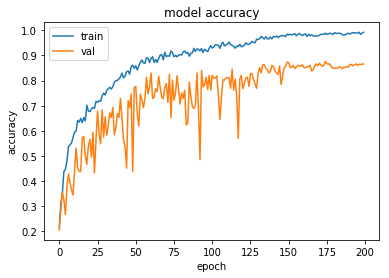

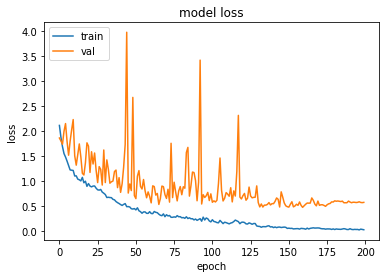

In [13]:
def display_history(history):
    # list all data in history
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(save_dir+'Stage_1_'+save_file+'_binary_acc.png')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(save_dir+'Stage_1_'+save_file+'_binary_loss.png')
    plt.show()
display_history(h)

In [14]:
model.save(save_dir+'Stage_2_'+save_file+'_final.h5')

In [15]:
model.evaluate_generator(valid_generator,verbose=1)

9/9 [==============================] - 9s 1s/step


[0.5784990699518294, 0.8666666746139526]

In [16]:
model = load_model(model_save_acc)

In [17]:
model.evaluate_generator(valid_generator,verbose=1)

9/9 [==============================] - 9s 993ms/step


[0.4995784303971699, 0.8761904835700989]